We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import shutil
import pandas

Let's create the frames.

In [ ]:

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

for i in glob.glob("../mp4/*.mp4"):
    destination = i.split('.mp4')[0]
    os.mkdir(destination)
    VidToFrames(i, destination)   

Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [19]:
from IPython.display import Image

def removeDimAndFadedImages(folderName):
    sortedFrameList = sorted(glob.glob(folderName+'/*.png'), key=os.path.getmtime)
    debugCount = 0
    for imagePath in sortedFrameList:
        brightness = getBrightnessOfImage(imagePath)
        if brightness < 9.4e7 or brightness > 4.5e8: # brightness < 6*10^7 or brightness > 7*10^8:
            print(imagePath, ": ", brightness)
            os.remove(imagePath)
        if debugCount % 100 == 0: 
            print (debugCount)
        debugCount +=1

        
def getBrightnessOfImage(imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        sums = np.sum(np.fromiter((index*hist[index] for index in range(len(hist))), dtype=float))
        vectors.append(sums)
        plt.plot(hist, color = col)
        plt.xlim([0, 256])
    plt.show()
    totalSums = np.sum(vectors)
    return totalSums

An image histogram gives a graphical representation of the distribution of pixel intensities in a digital image.

In [73]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, edgecolor="yellow", color="green")
    plt.show()

low diff = :  0.0
frames/lineart/[lineart]i was gonna delete this but you guys told me not to-iVqhzEaJhDw/273.png


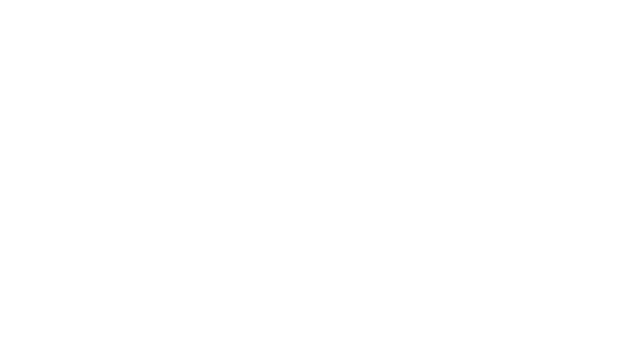

frames/lineart/[lineart]i was gonna delete this but you guys told me not to-iVqhzEaJhDw/274.png


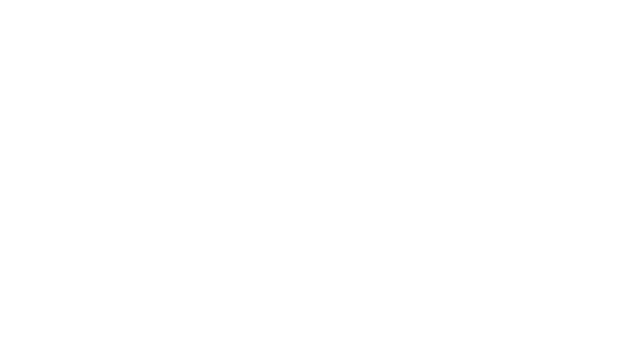

37 out of 1129 files were duplicates


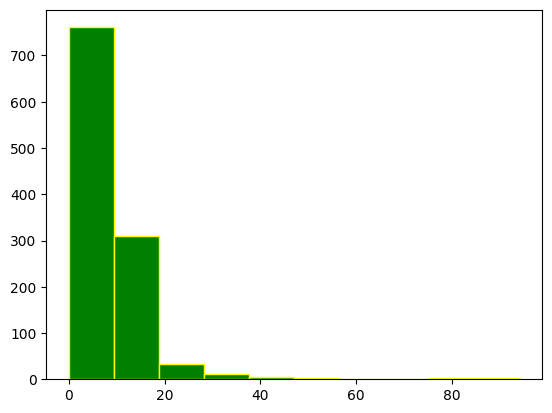

DIFF min:  0.0  max:  94.05469 mean:  8.618614 


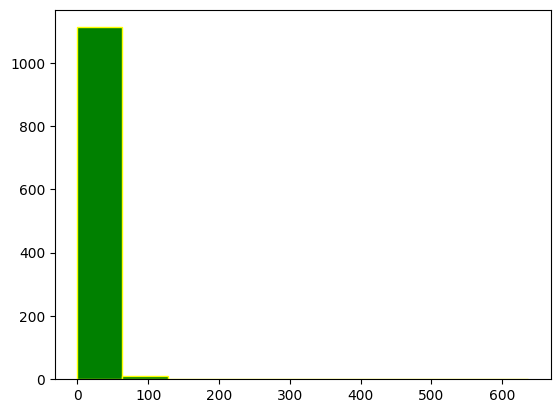

MSE min:  0.0  max:  637.0105555555556 mean:  4.005593286729216 
low diff = :  0.0
frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/0.png


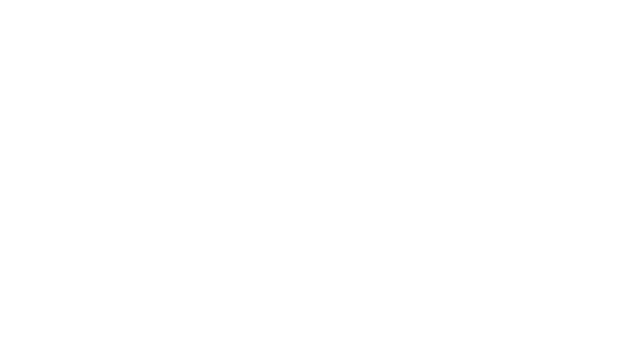

frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/1.png


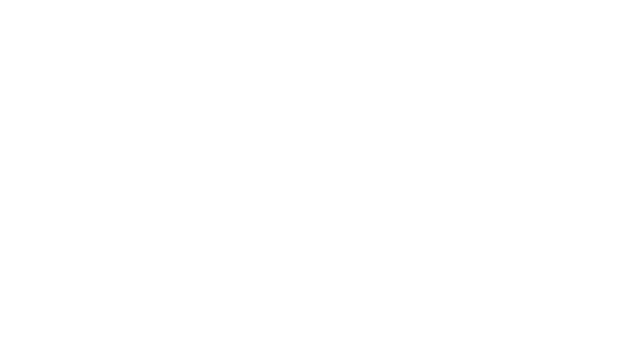

mid diff = :  126.96094
frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/301.png


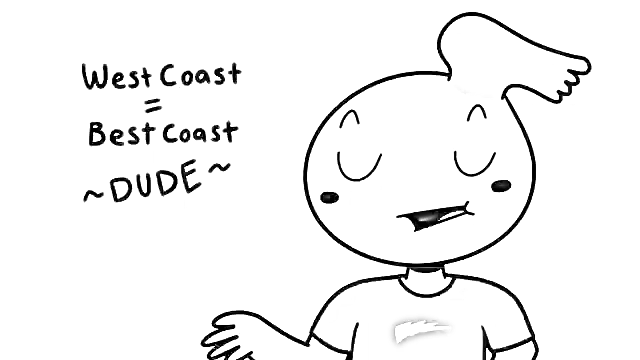

frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/302.png


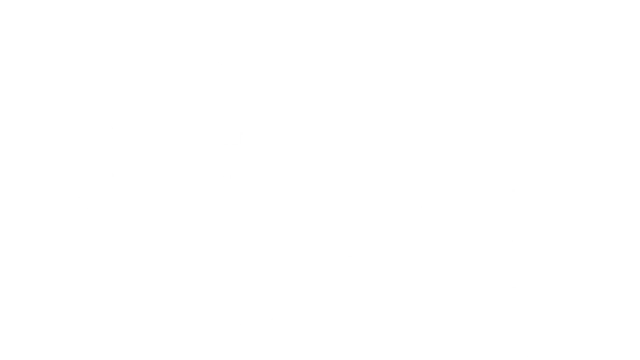

high diff = :  275.54688
frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/559.png


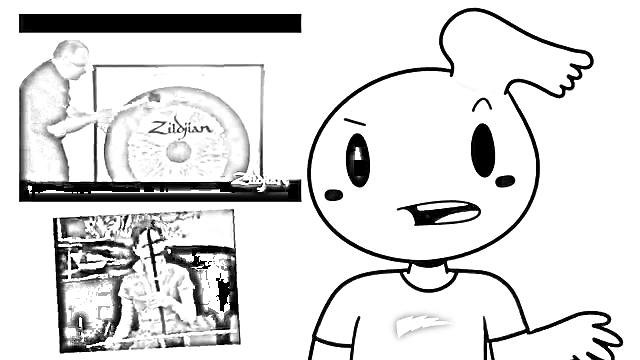

frames/lineart/[lineart]Being a Boba Barista (Work Stories)-so1_5hYUEE8/560.png


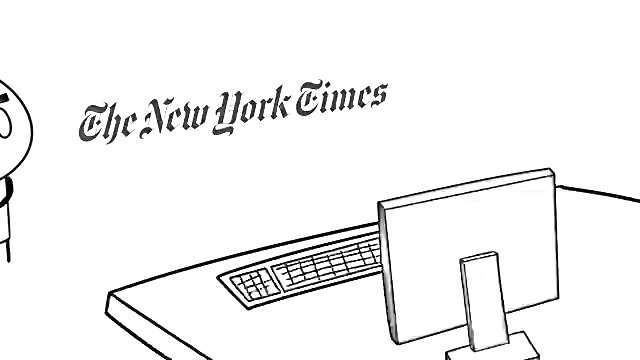

5807 out of 9584 files were duplicates


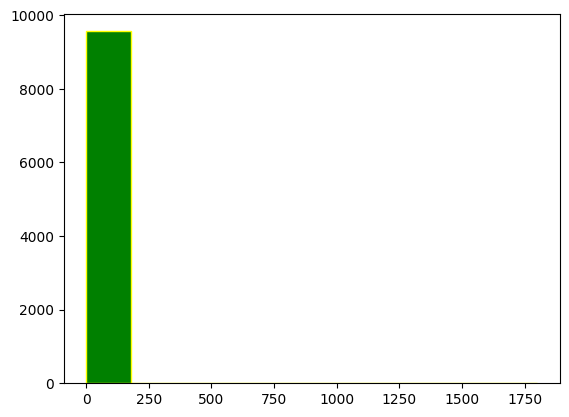

DIFF min:  0.0  max:  1800.0 mean:  5.462136 


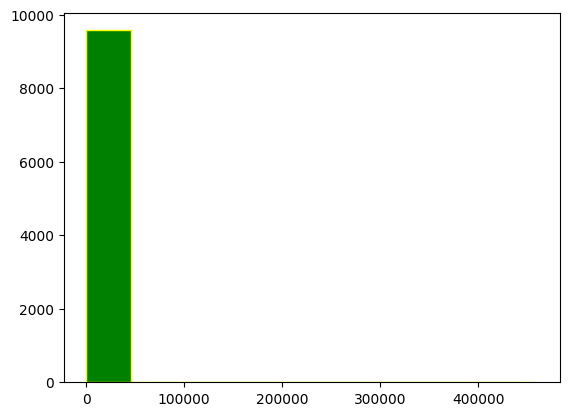

MSE min:  0.0  max:  460080.9244444444 mean:  111.91795814184115 


In [66]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display

HEIGHT  = 720
WIDTH = 1280
DIFF= 1
def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (vA, vB):
    return np.sum(np.square(np.subtract(vA, vB)))

def DIFF_images(vA, vB):
    return (np.abs(vA - vB)).mean()

def removeLowDiff_andDemo(folderName):
    lenOfFrameList = len(glob.glob(glob.escape(folderName)+'/*.png')) #unfortunately, doesn't work bc sortByInt isn't a thing
    filesMoved = 0 
    validFrameList = []

    lowRangeDone= False
    midRangeDone= False
    highRangeDone= False

    listOfMSE = []
    listOfDIFF = []

    imageShape = cv2.imread('{}/{}.png'.format(folderName, 0)).shape
    h,w,c = imageShape
    for i in range(lenOfFrameList-1):
        firstFrame = '{}/{}.png'.format(folderName, i)
        secondFrame = '{}/{}.png'.format(folderName, i+1)
        f1_v = getFeatureVectorOfImage(firstFrame)
        f2_v = getFeatureVectorOfImage(secondFrame)
        diff = DIFF_images(f1_v, f2_v)
        mse = MSE_images(f1_v, f2_v)/ (h*w)
        listOfDIFF.append(diff)
        listOfMSE.append(mse)

        if (diff >=  DIFF):
            validFrameList.append(firstFrame)
            filesMoved+=1
        # if (lowRangeDone and midRangeDone and highRangeDone) == False:
        #     if (diff == 0 and not lowRangeDone):
        #         print ("low diff = : ", diff)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         lowRangeDone = True
        #     if (diff > 100 and diff < 150  and not midRangeDone):
        #         print ("mid diff = : ", diff)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         midRangeDone = True
        #     if (diff > 250 and diff < 300  and not highRangeDone):
        #         print ("high diff = : ", diff)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         highRangeDone = True
    print(lenOfFrameList - filesMoved, "out of", lenOfFrameList, "files were duplicates")
    
    binAndPlot(listOfDIFF)
    print("DIFF min: ", np.amin(listOfDIFF), " max: ", np.amax(listOfDIFF), "mean: ", np.mean(listOfDIFF), "")
    binAndPlot(listOfMSE)
    print("MSE min: ", np.amin(listOfMSE), " max: ", np.amax(listOfMSE), "mean: ", np.mean(listOfMSE), "")

    return validFrameList
            

for lineartPath in glob.glob("frames/lineart/*")[3:5]:
    removeLowDiffDst = removeLowDiff_andDemo(lineartPath)
    print("===============================================================================")

In [20]:

def detectScenes(folderName, diff):
    with open(folderName+"_sceneDetection.txt", 'w') as f:
        sortedFrameList = sorted(glob.glob(folderName+'*.png'), key=os.path.getmtime)
        startOfShot=0
        numberOfScenes = 0
        lengthOfScene = 0
        for index in len(sortedFrameList-1):
            if MSE_images(sortedFrameList[index], sortedFrameList[index+1]) > diff:
                if lengthOfScene > 8:
                    f.write(startOfShot, ", ", index)
                    numberOfScenes += 1
                startOfShot = index+1
                lengthOfScene = 0


### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

In [1]:
#XDoG
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import sys
from scipy.ndimage.filters import gaussian_filter
from torchvision import transforms
import cv2
import glob

def xdog(original, count, lineartPath, epsilon=0.5, phi=10, k=1.4, tau=1, sigma=0.5):
    image = cv2.imread(original, cv2.IMREAD_GRAYSCALE)
    image = gaussian_filter(image, 0.7)
    gauss1 = gaussian_filter(image, sigma)
    gauss2 = gaussian_filter(image, sigma*k)

    D = gauss1 - tau*gauss2

    U = D/255
    
    for i in range(0,len(U)):
        for j in range(0,len(U[0])):
            U[i][j] = abs(1-U[i][j])
    for i in range(0, len(U)):
        for j in range(0, len(U[0])):
            if U[i][j] >= epsilon:
                U[i][j] = 1
            else:
                ht = np.tanh(phi*(U[i][j] - epsilon))
                U[i][j] = 1 + ht

    lineart = U*255
    success = cv2.imwrite(lineartPath+"/%d.png" % count, lineart)

def dodgeV2(x, y):
    return cv2.divide(x, 255 - y, scale=256)

def xdog2 (original, lineartPath):
    img = cv2.imread(original)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_invert = cv2.bitwise_not(img_gray)
    img_smoothing = cv2.GaussianBlur(img_invert, (21, 21),sigmaX=0, sigmaY=0)
    final_img = dodgeV2(img_gray, img_smoothing)

    success = cv2.imwrite(lineartPath+original.split('/')[-1], final_img)     # save frame as JPEG file      


Get lineart for all frames

In [ ]:
def ColorToLineart (framepath):
    lineartpath = "[lineart]"+ framepath.split('/')[-2]+"/"
    os.mkdir(lineartpath)
    print(lineartpath)
    imgList = glob.glob('%s/*'% framepath)
    count=0
    for i in imgList:
        try:
            xdog2(i, lineartpath)
            count+=1
        except:
            print(lineartpath)
    print(count, "out of", len(imgList), " files converted to lineart")
    

for framepath in glob.glob("frames/*/")[1:]:
    print(framepath)
    ColorToLineart(framepath)


 There was a time when I was interested in colorization machine learning techniques. Honestly, I still am, just less than this project. 

 There was a paper called [Deep Line Art Video Colorization with a Few References](https://arxiv.org/abs/2003.10685) that I spent some time generating data for. It was only after I generated all the data that I realized I don't have the resources (GPU, money, honestly, motivation was the biggest factor)

> We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
768-dimensional feature vector of histograms of R, G, B channels
for each frame. The difference between frames is determined by
calculating the mean square error of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is greater than 200, it
is considered to belong to different shots. In order to improve the
quality of the data, we remove shots in which the mean square
errors between all pairs of frames are less than 10 (as they are
too uniform), and the shot with a length less than 8 frames.
Then we filter out video frames that are too dark or too faded
in color. Finally we get a total of 1096 video sequences from 6
animations, with a total of 29,834 images. Each video sequence
has 27 frames on average. 

In my case, I got around 28k iumages with 32 frames per scene on average.

I'm going to use the data collection method stated above, with a slight variation


In [67]:
with open('../channelId_to_mostViewedVidId.json', 'r') as j:
    channelId_to_mostViewedVidId = json.loads(j.read())

LIST_OF_CHANNEL_IDS= channelId_to_mostViewedVidId.keys()

In [70]:
with open('../masterSheet.json', 'r') as j:
    masterSheet = json.loads(j.read())

channelId_to_mostViewedVidInfo = {}

for channelId in LIST_OF_CHANNEL_IDS:
    mostViewedVidId = channelId_to_mostViewedVidId[channelId]
    for vidInfo in masterSheet[channelId]:
        if vidInfo['vidId'] == mostViewedVidId:
            channelId_to_mostViewedVidInfo[channelId] = vidInfo
channelId_to_mostViewedVidInfo


{'UCsDmESjqNPukDmVnuneLrqw': {'vidId': 'EcgkRp2IUsc',
  'publishTime': '2017-10-26T01:05:22Z',
  'vidTitle': 'My Hot Babysitter Got Me In Trouble',
  'duration': 'PT6M30S',
  'viewCount': 35958011,
  'likeCount': 840535,
  'commentCount': 75600,
  'topicCategories': ['https://en.wikipedia.org/wiki/Entertainment',
   'https://en.wikipedia.org/wiki/Film'],
  'description': "First Name Babysitter. Last Name Trouble. \nGET T-SHIRTS: http://www.itsalexclark.com \nSEE ME ON TOUR: http://www.itsalexclark.com/tour\n\nThanks to Shgurr and PamonSunset:\nhttps://www.youtube.com/channel/UCkQ3eqNNaFrBZ_WbnCIMN8w\n\nSubscribe: http://bit.ly/SubAlexClark | Get ItsAlexClark merch: http://itsalexclark.bigcartel.com/ \nWatch my latest video: https://youtube.com/watch?v=YIiBGDBN-Po&list=PLmh1WGagp73Jbndkw6nCz2JCm73jEp8gh\nHelp out the channel: https://Patreon.com/itsalexclark\n\nFollow ItsAlexClark!\nFacebook: https://facebook.com/itsalexclark/?ref=br_rs\nInstagram: https://instagram.com/itsalexclark/\nT

In [72]:
df = pandas.DataFrame.from_dict(channelId_to_mostViewedVidInfo).T
df

,vidId,publishTime,vidTitle,duration,viewCount,likeCount,commentCount,topicCategories,description
UCsDmESjqNPukDmVnuneLrqw,EcgkRp2IUsc,2017-10-26T01:05:22Z,My Hot Babysitter Got Me In Trouble,PT6M30S,35958011,840535,75600,"[https://en.wikipedia.org/wiki/Entertainment, ...",First Name Babysitter. Last Name Trouble. \nGE...
UCY6Ij8zOds0WJEeqCLOnqOQ,kbCah6yhYRs,2019-06-11T11:00:07Z,Descendants doesn&#39;t make any sense...,PT16M8S,9806120,262432,22460,"[https://en.wikipedia.org/wiki/Entertainment, ...",Descendants doesn't make any sense animation\n...
UClN24S5-fc7LD0JJW0FdGWw,ewsGmhAjjjI,2018-10-09T20:50:50Z,I have APHANTASIA (and you may too...without r...,PT12M54S,6026056,319132,71950,"[https://en.wikipedia.org/wiki/Hobby, https://...",So...yeah. I'm an artist that can't see pictur...
UC3iNdSV_RQU7DHTGpqEW96w,gA0bi-bFEYs,2018-06-22T19:20:36Z,How KSI Saved Logan Paul&#39;s Career,PT6M48S,20317731,513706,95771,"[https://en.wikipedia.org/wiki/Entertainment, ...",This KSI vs Logan Paul fight is interesting to...
UC_52i6mlrzOZs_NEuSepzAg,so1_5hYUEE8,2017-09-20T22:12:54Z,Being a Boba Barista (Work Stories),PT5M20S,2196478,58179,3759,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,Get it? “B”eing a “B”oba “B”arista “b”y “B”ill...
UCr3cBLTYmIK9kY0F_OdFWFQ,xa-4IAR_9Yw,2016-03-29T09:20:12Z,Casually Explained: Is She Into You?,PT2M31S,17115808,736729,20174,"[https://en.wikipedia.org/wiki/Entertainment, ...",Based on a true story. Dedicated to Jimmy. Unr...
UCV6g95OBbVtFmN9uiJzkFqQ,I9uWUw1fxOY,2020-10-23T15:59:47Z,The Life of a Speedrunner,PT1M1S,19333474,833043,20375,[https://en.wikipedia.org/wiki/Video_game_cult...,"ANOTHER DAY, ANOTHER CHANCE TO OPTIMIZE THIS R..."
UCgCKYs56-LKEPGQ99DzqQOg,W8P5ewPk9fM,2019-01-18T20:00:06Z,Why I Dont Want a Hot Wife (Ft. Emirichu),PT8M7S,2318935,115419,5846,[https://en.wikipedia.org/wiki/Entertainment],"This week, we talk about one of the things I g..."
UCOwxx9VnEnlFKt5EB70KTzQ,12Ne9n40tmw,2017-02-25T19:46:48Z,WHO&#39;S YOUR DADDY? ANIMATED with Pewdiepie ...,PT2M26S,11704475,246749,6180,[],Animating Pewdiepie and Jacksepticeye's who's ...
UC2Ds30pkifFVD0CE08wF50g,Mv8OkBjySGQ,2017-09-15T00:08:53Z,My Super HOT English Teacher (Animation),PT8M5S,9249114,303683,26328,"[https://en.wikipedia.org/wiki/Entertainment, ...","I have so many more stories, so subscribe and ..."


couple that do not fit the criteria:

vidIds [kQEtRoyFfI8- gameplay, hpQQohcHk9Q- too short. not commentary, 6wS_uON5s6Q- speeddrawing, RlU32AfEVeU- footage apparently from another youtuber, iVqhzEaJhDw- too short, Xnv7JGqjaAo- speeddraw, iRBmUQQzpWQ- simply not animation, 18msRdBF11A- not animation, Ln4AnsWNUQI- not animation, Hkz0NcKPzMs- too short]



In [1]:
not_candidate_vidIds= ['kQEtRoyFfI8', 'hpQQohcHk9Q', '6wS_uON5s6Q', 'RlU32AfEVeU', 'iVqhzEaJhDw', 'Xnv7JGqjaAo', '18msRdBF11A', 'Ln4AnsWNUQI', 'Hkz0NcKPzMs']